# Reduced fragment library

## Aim of this notebook

The fragment library resulting from the KinFragLib fragmentation procedure comprises of about 3000 fragments. Ultimately, we want to demonstrate how this library can be used for recombining ligands. Before this can be done, we need to address two considerations:

1. Remove all fragments that are not useful in a recombination, i.e. duplicates, fragments in pool X, fragments without dummy atoms, and fragments with dummy atoms only connecting to pool X.
2. Select a diverse set of fragments (per subpocket) for recombination to (i) save computational cost and (ii) avoid recombination of highly similar fragments.

Furthermore, we want to know (i) which original ligands can be fully recombined by the reduced fragment library and (ii) how many original ligands are represented by at least one fragment. This will help us to check our combinatorial library for expected results.

## Table of contents

1. Load fragment library (from csv file)
2. Filter fragment library
3. Cluster and select filtered fragments (get diverse set of fragments)
4. Look at selected fragments
5. Load fragment library (from sdf files)
6. Which fragments in the full library are in the reduced library?
7. How many ligands are fully covered by the reduced library?
8. Save reduced fragment library (as sdf files and csv file)

## Notebook dependencies

Needs output from notebook `fragment_library.ipynb`.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools

from util import *
import klifs_utils

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [4]:
# Path to data
PATH_DATA = Path('.') / '..' / 'data'

# Create new folder for reduced fragment library
(PATH_DATA / 'fragment_library_reduced').mkdir(parents=True, exist_ok=True)

# Butina clustering: distance cutoff
DISTANCE_CUTOFF = 0.6

# Select fragments from clusters: Most common fragment per cluster (if mulitple most common fragments, select the one most similar to cluster centroid)
# (A) Select always one fragment per cluster
#N_REPRESENTED_FRAGMENTS = None
# (B) Select top X most common fragments per cluster, whereby X is depending on cluster size (20 clustered fragments will be represented by one selected fragment)
#N_REPRESENTED_FRAGMENTS = 20
N_REPRESENTED_FRAGMENTS = 10

# Do we want to include fragment from singleton clusters?
INCLUDE_SINGLETONS = True

## 1. Load fragment library (from csv file)

(7486, 13)


,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,subpocket,atom_subpockets,atom_environments,smiles,smiles_dummy_atoms,ROMol
0,AAK1,NAK,Other,5l4q,LKB,B,A,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,
1,AAK1,NAK,Other,5te0,XIN,,A,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,

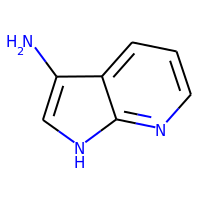
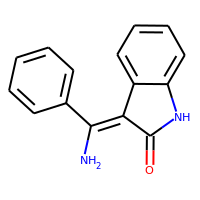

In [5]:
fragment_library_concat = pd.read_csv('../data/fragment_library/fragment_library.csv')
PandasTools.AddMoleculeColumnToFrame(fragment_library_concat, 'smiles')

print(fragment_library_concat.shape)
fragment_library_concat.head(2)

In [6]:
fragment_library_concat.groupby('subpocket', sort=False).size()

subpocket
AP    2561
FP    1866
SE    1560
GA    1024
B1      98
B2      92
X      285
dtype: int64

## 2. Filter fragment library

Filter steps:

1. Remove pool X
2. Deduplicate fragment library (per subpocket)
3. Remove fragments without dummy atoms (unfragmented ligands)
4. Remove all fragments that connect only to pool X
5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)

### 2.1. Remove pool X

In [7]:
# Remove pool X
fragment_library_concat_filtered = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()
print(fragment_library_concat_filtered.shape)
fragment_library_concat_filtered.subpocket.unique()

(7201, 13)


array(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'], dtype=object)

### 2.2. Deduplicate fragment library (per subpocket)

In [8]:
# Get fragment count (by SMILES) per subpocket
fragment_count = fragment_library_concat_filtered.groupby(
    ['subpocket', 'smiles'],
    sort=False
).size()

In [9]:
# Get first occurrence of SMILES per subpocket
fragment_library_concat_filtered = fragment_library_concat_filtered.groupby(
    ['subpocket', 'smiles'],
    sort=False
).first()

(2977, 14)


,subpocket,smiles,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy_atoms,ROMol,fragment_count
0,AP,Nc1c[nH]c2ncccc12,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,,3
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,,3

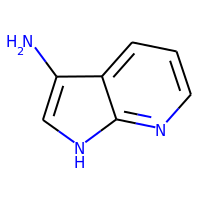
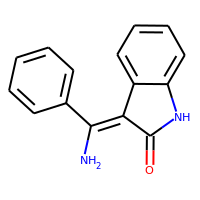

In [10]:
# Add fragment count to these representative fragments
fragment_library_concat_filtered['fragment_count'] = fragment_count
fragment_library_concat_filtered.reset_index(inplace=True)

print(fragment_library_concat_filtered.shape)
fragment_library_concat_filtered.head(2)

In [11]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1115
FP     864
SE     607
GA     306
B1      42
B2      43
dtype: int64

### 2.3. Remove fragments without dummy atoms (unfragmented ligands)

In [12]:
# Get fragments' (subpocket) connections 
fragment_library_concat_filtered['connections'] = get_connections_by_fragment(fragment_library_concat_filtered).connections

In [13]:
# Unfragmented ligands?
bool_unfragmented_ligands = fragment_library_concat_filtered.connections.apply(lambda x: len(x) == 0)
bool_unfragmented_ligands.head()

0    False
1    False
2    False
3    False
4    False
Name: connections, dtype: bool

In [14]:
# Remove unfragmented ligands
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_unfragmented_ligands
].copy()
print(fragment_library_concat_filtered.shape)

(2863, 16)


In [15]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1001
FP     864
SE     607
GA     306
B1      42
B2      43
dtype: int64

### 2.4. Remove all fragments that connect only to pool X

In [16]:
# Fragment connects only to pool X?
bool_only_pool_x_connections = fragment_library_concat_filtered.connections.apply(
    lambda x: all(  # All connections per fragment X?
        [True if 'X' in i else False for i in x]  # Connections per fragment X or not?
    )
)

In [17]:
# Remove fragments that connect only to pool X
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_only_pool_x_connections
].copy()
print(fragment_library_concat_filtered.shape)

(2862, 16)


In [18]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1001
FP     864
SE     607
GA     306
B1      42
B2      42
dtype: int64

### 2.5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)

Rule of Three criteria ([paper](https://www.sciencedirect.com/science/article/pii/S1359644603028319)):
- Molecular weight < 300 Da
- LogP <= 3
- Number of HBA <= 3 
- Number of HBD <= 3
- Number of rotatable bonds <= 3 
- Polar surface area (PSA) <= 60 $\mathring{A}$<sup>2</sup>

In [19]:
ro3 = fragment_library_concat_filtered.ROMol.apply(lambda x: get_ro3_from_mol(x))

In [20]:
# Fragments fulfill all six Ro3 rules
bool_fulfill_ro3 = ro3.sum(axis=1) == 6

In [21]:
fragment_library_concat_filtered = fragment_library_concat_filtered[
    bool_fulfill_ro3
].copy()
print(fragment_library_concat_filtered.shape)

(2029, 16)


In [22]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    516
FP    655
SE    501
GA    278
B1     39
B2     40
dtype: int64

## 3. Cluster and select filtered fragments (get diverse set of fragments)

### Fragment clustering per subpocket

In [23]:
def cluster_fragments(fragments, cutoff):
    """
    Cluster fragments using the Butina algorithm with a given distance cutoff.
    
    Parameters
    ----------
    fragments : pandas.DataFrame
        Fragments.
    cutoff : float
        Distance cutoff Butina clustering.
        
    Returns
    -------
    pandas.DataFrame
        Clustered fragments, containing fragment details available from input plus cluster details (fragments' cluster IDs, cluster member ID, 
        cluster size, and molecule ID).
    """

    # Get fragments by subpocket
    fragments = fragments.copy()
    fragments.reset_index(inplace=True, drop=True)
    fragments.index.name = 'molecule_id'

    # Cluster molecules
    clustered_fragments = cluster_molecules(fragments.ROMol, cutoff)
    
    # Concatenate cluster metadata with fragment details
    clustered_fragments = fragments.merge(
        clustered_fragments,
        on='molecule_id',
    )
    
    return clustered_fragments

### Fragment selection per subpocket

In [24]:
def select_fragments_from_clusters(clustered_fragments, n_represented_fragments=None):
    """
    Select fragments from clusters - two options: 
    (A) Get most common fragment. In case of mulitple most common fragments, select the one that is most similar to cluster centroid.
    (B) Get top X most common fragments, whereby X depends on the cluster size (more fragments will be selected from larger clusters).
    
    Parameters
    ----------
    clustered_fragments : pandas.DataFrame
        Fragments with cluster details (cluster ID, cluster size, cluster member ID, and molecule ID).
    n_represented_fragments : None or int
        Default: Select first fragment per sorted cluster (None). 
        Alternative: Select top X fragments per sorted cluster, whereby X depends on cluster size (n_cluster_fragments): 
        X = n_cluster_fragments / n_represented_fragments.
        
    Returns
    -------
    pandas.DataFrame
        Fragments selected from clusters, including cluster IDs, cluster member ID, cluster size, and molecule ID.
    """
    
    # Sort DataFrame by cluster ID (ascending), fragment count (descending), and cluster member ID (ascending)
    # Note member ID: the smaller, the more similar to cluster centroid
    clustered_fragments.sort_values(
        ['cluster_id', 'fragment_count', 'cluster_member_id'], 
        ascending=[True, False, True], 
        inplace=True
    )

    # Select fragment per cluster by (i) fragment count and (i) similarity to cluster centroids (cluster member ID):
    
    # Option A: Select first fragment per sorted cluster
    if n_represented_fragments is None:
        selected_fragments = clustered_fragments.groupby('cluster_id', sort=False).first()
        selected_fragments.reset_index(inplace=True)
        selected_fragments['cluster_size'] = clustered_fragments.groupby('cluster_id', sort=False).size()
    
    # Option B: Select top X fragments per sorted cluster, whereby X depends on the cluster size (e.g. per 20 fragments select one)
    else:
        selected_fragments = clustered_fragments.groupby('cluster_id', sort=False).apply(
            lambda x: x.head(math.ceil(len(x) / n_represented_fragments))
        )
        selected_fragments.reset_index(inplace=True, drop=True)
        selected_fragments['cluster_size'] = [clustered_fragments.groupby('cluster_id', sort=False).size().loc[cluster_id] for cluster_id in selected_fragments.cluster_id]
    
    print(f'Number of selected fragments / clusters / inital fragments: {selected_fragments.shape[0]} / {clustered_fragments.cluster_id.unique().shape[0]} / {clustered_fragments.shape[0]}')
    
    return selected_fragments

### Fragment clustering and selection for all subpockets (individually)

In [25]:
def select_fragments_from_clusters_all_subpockets(fragment_library_concat, cutoff, n_represented_fragments=None):
    """
    Cluster fragments and select cluster representatives for mulitple subpockets individually:
    1. Cluster fragments using the Butina algorithm with a given distance cutoff.
    2. Select fragments from clusters - two options: 
       (A) Get most common fragment. In case of mulitple most common fragments, select the one that is most similar to cluster centroid.
       (B) Get top X most common fragments, whereby X depends on the cluster size (more fragments will be selected from larger clusters).
    
    Parameters
    ----------
    fragment_library_concat : pandas.DataFrame
        Fragment library data for one or multiple subpockets.
    cutoff : float
        Distance cutoff Butina clustering.
    n_represented_fragments : None or int
        Default: Select first fragment per sorted cluster (None). 
        Alternative: Select top X fragments per sorted cluster, whereby X depends on cluster size (n_cluster_fragments): 
        X = n_cluster_fragments / n_represented_fragments.
    
    Returns
    -------
    pandas.DataFrame
        Fragments selected from clustering, including cluster IDs, cluster member ID, cluster size, and molecule ID (clustering per subpocket individually).   
    """
    
    selected_fragments_subpockets = {}

    for subpocket, fragments in fragment_library_concat.groupby('subpocket', sort=False):
        
        print(f'\nSubpocket: {subpocket}')
        
        clustered_fragments_subpocket = cluster_fragments(fragments, cutoff)
        selected_fragments_subpocket = select_fragments_from_clusters(clustered_fragments_subpocket, n_represented_fragments)
        
        selected_fragments_subpocket['subpocket'] = subpocket
        selected_fragments_subpockets[subpocket] = selected_fragments_subpocket

    # Concatenate cluster centroids for all subpockets
    selected_fragments = pd.concat(selected_fragments_subpockets).reset_index(drop=True)
    
    return selected_fragments

In [26]:
selected_fragments = select_fragments_from_clusters_all_subpockets(
    fragment_library_concat_filtered, 
    DISTANCE_CUTOFF, 
    n_represented_fragments=N_REPRESENTED_FRAGMENTS
)


Subpocket: AP
Number of molecules: 516
Threshold:  0.6
Number of clusters:  133
# Clusters with only 1 molecule:  70
# Clusters with more than 5 molecules:  21
# Clusters with more than 25 molecules:  1
# Clusters with more than 100 molecules:  0
Number of selected fragments / clusters / inital fragments: 154 / 133 / 516

Subpocket: FP
Number of molecules: 655
Threshold:  0.6
Number of clusters:  170
# Clusters with only 1 molecule:  83
# Clusters with more than 5 molecules:  29
# Clusters with more than 25 molecules:  4
# Clusters with more than 100 molecules:  0
Number of selected fragments / clusters / inital fragments: 192 / 170 / 655

Subpocket: SE
Number of molecules: 501
Threshold:  0.6
Number of clusters:  120
# Clusters with only 1 molecule:  58
# Clusters with more than 5 molecules:  19
# Clusters with more than 25 molecules:  4
# Clusters with more than 100 molecules:  0
Number of selected fragments / clusters / inital fragments: 140 / 120 / 501

Subpocket: GA
Number of mol

,cluster_id,cluster_size,fragment_count,cluster_member_id,molecule_id,ROMol
0,1,78,25,7,21,
1,1,78,18,5,13,
2,1,78,15,46,298,
3,1,78,11,8,32,
4,1,78,11,34,192,

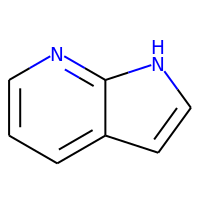
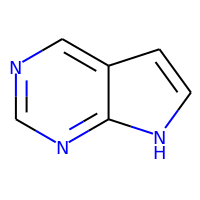
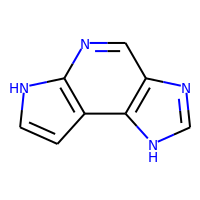
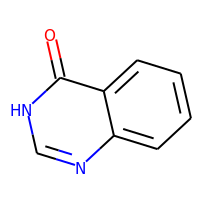
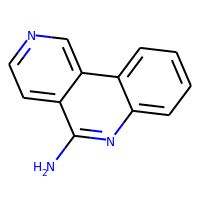

In [27]:
selected_fragments[['cluster_id', 'cluster_size', 'fragment_count', 'cluster_member_id', 'molecule_id', 'ROMol']].head()

### Plot cluster sizes per subpocket

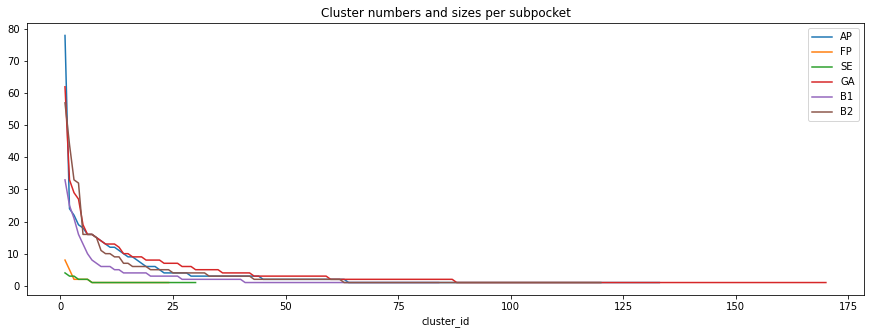

In [28]:
# Get cluster size per subpocket and cluster
cluster_data = selected_fragments.groupby(
    ['subpocket', 'cluster_id']
).first()['cluster_size'].reset_index()

# Reformat cluster data for plotting (subpocket per column)
cluster_data = pd.concat(
    [
        subpocket_data.set_index('cluster_id')['cluster_size'] 
        for subpocket, subpocket_data 
        in cluster_data.groupby('subpocket', sort=False)
    ], 
    axis=1
)
cluster_data.columns = selected_fragments.groupby('subpocket', sort=False).groups.keys()

# Plot cluster data
cluster_data.plot(figsize=(15,5), title='Cluster numbers and sizes per subpocket')

### Include singletons?

In [29]:
print(f'Number of selected fragments with singletons: {selected_fragments.shape[0]}')

if INCLUDE_SINGLETONS:
    pass
else:
    selected_fragments = selected_fragments[selected_fragments.cluster_size!=1]
    print(f'Number of selected fragments without singletons: {selected_fragments.shape[0]}')
    
print(f'Include singletons: {INCLUDE_SINGLETONS}')
print(f'Number of selected fragments in final set: {selected_fragments.shape[0]}')

Number of selected fragments with singletons: 633
Include singletons: True
Number of selected fragments in final set: 633


## 4. Look at selected fragments

### Number of fragments per subpocket and in total

In [30]:
selected_fragments.groupby('subpocket', sort=False).size()

subpocket
AP    154
FP    192
SE    140
GA     93
B1     24
B2     30
dtype: int64

In [31]:
print(f'Number of centroids in total = size of reduced fragment library: {selected_fragments.shape[0]}')

Number of centroids in total = size of reduced fragment library: 633


In [32]:
def draw_selected_fragments(selected_fragments, output_path=None):
    """
    Draw selected fragments sorted by descending cluster size (show legend cluster ID | cluster size | fragment count | cluster member ID).
    
    Parameters
    ----------
    cluster_centroids : pandas.DataFrame
        Fragments that are cluster centroids (cluster ID as index, molecule ID, cluster size, and ROMol).   
    output_path : pathlib.Path
        Path to output folder.
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments sorted by descending cluster size.
    """
    
    subpocket = selected_fragments.subpocket.unique()[0]
        
    img = Draw.MolsToGridImage(
        list(selected_fragments.ROMol), 
        legends=[
            f'{row.cluster_id} | {row.cluster_size} | {row.fragment_count} | {row.cluster_member_id}' 
            for index, row
            in selected_fragments.iterrows()
        ],  
        molsPerRow=7, 
        maxMols=200,
        subImgSize=(170, 170),
        useSVG=True
    )
    
    print(f'Legend: cluster ID | cluster size | fragment count | cluster member ID')
    
    if output_path is not None:
        
        # Get SVG data
        molsvg = img.data

        # Set font size
        molsvg = molsvg.replace('12px', '24px');

        # Save altered SVG data to file
        with open(Path(output_path) / f'clustered_most_common_fragments_{subpocket.lower()}.svg', 'w') as f:
            f.write(molsvg)
    
    return img

### Fragments in AP

Legend: cluster ID | cluster size | fragment count | cluster member ID


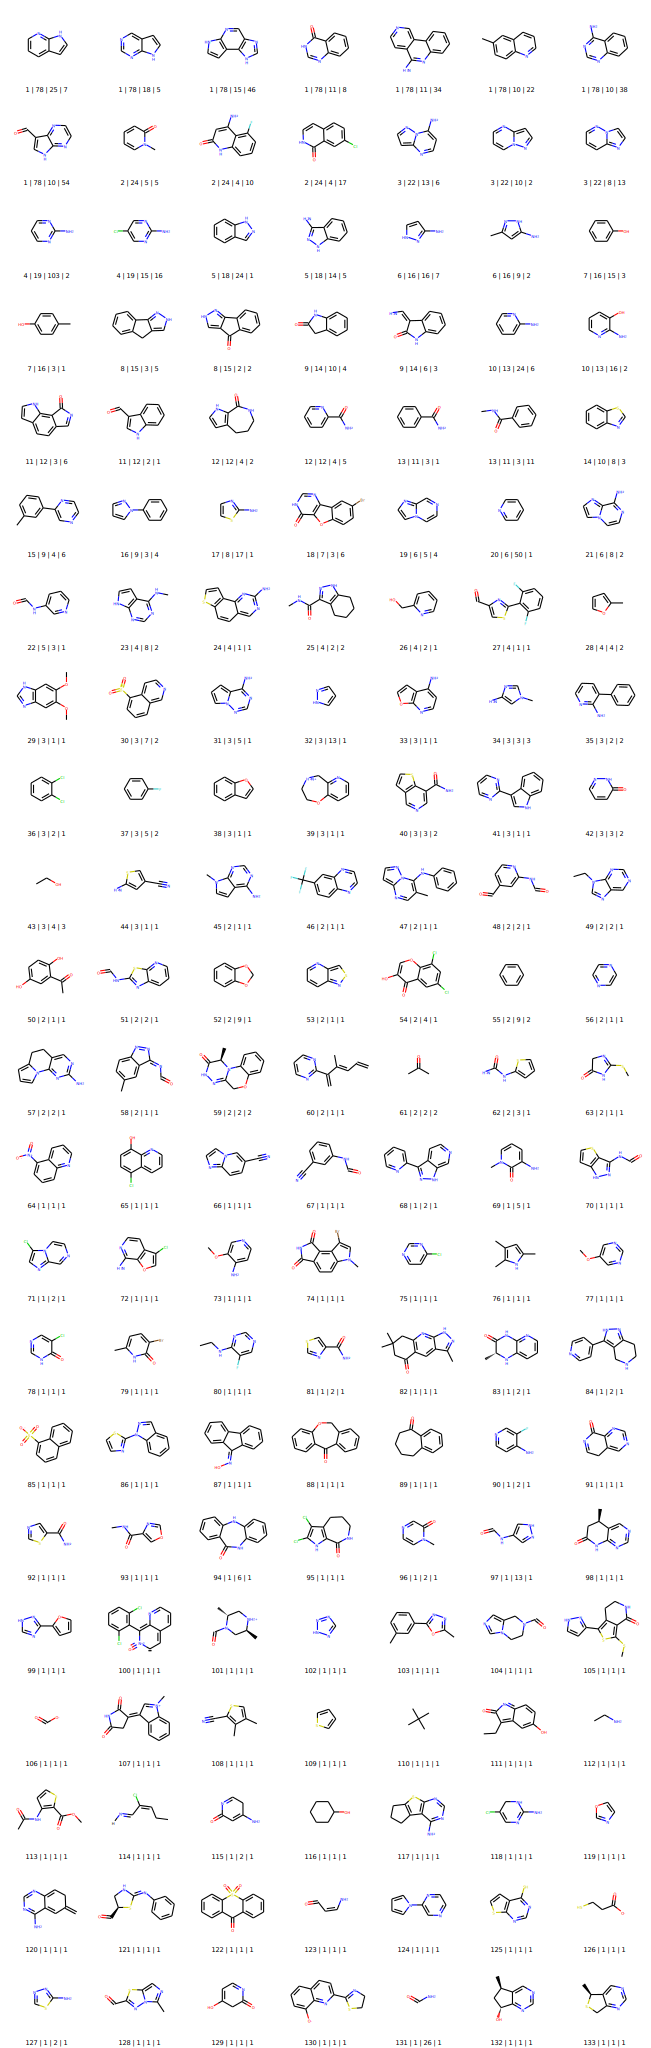

In [33]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('AP'), output_path=None)

### Fragments in FP

Legend: cluster ID | cluster size | fragment count | cluster member ID


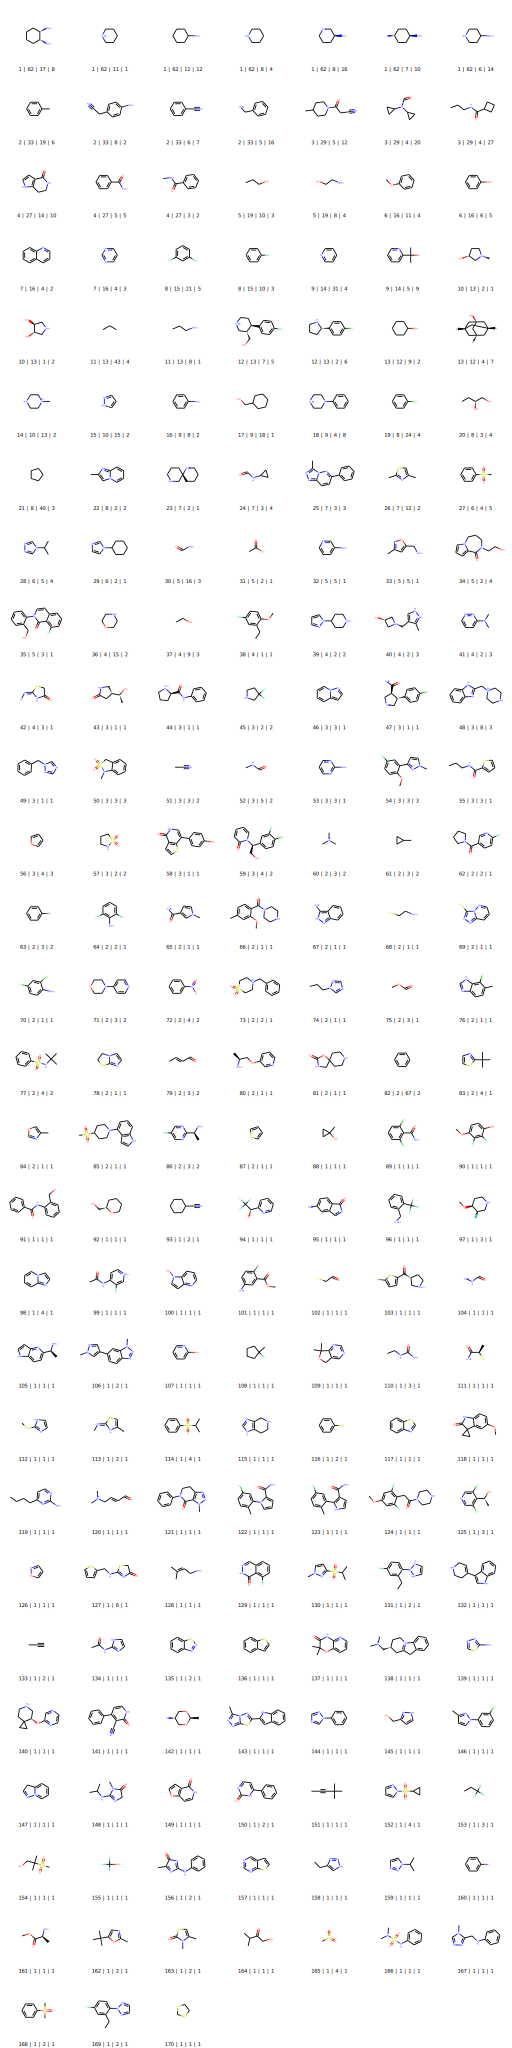

In [34]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('FP'), output_path=None)

### Fragments in SE

Legend: cluster ID | cluster size | fragment count | cluster member ID


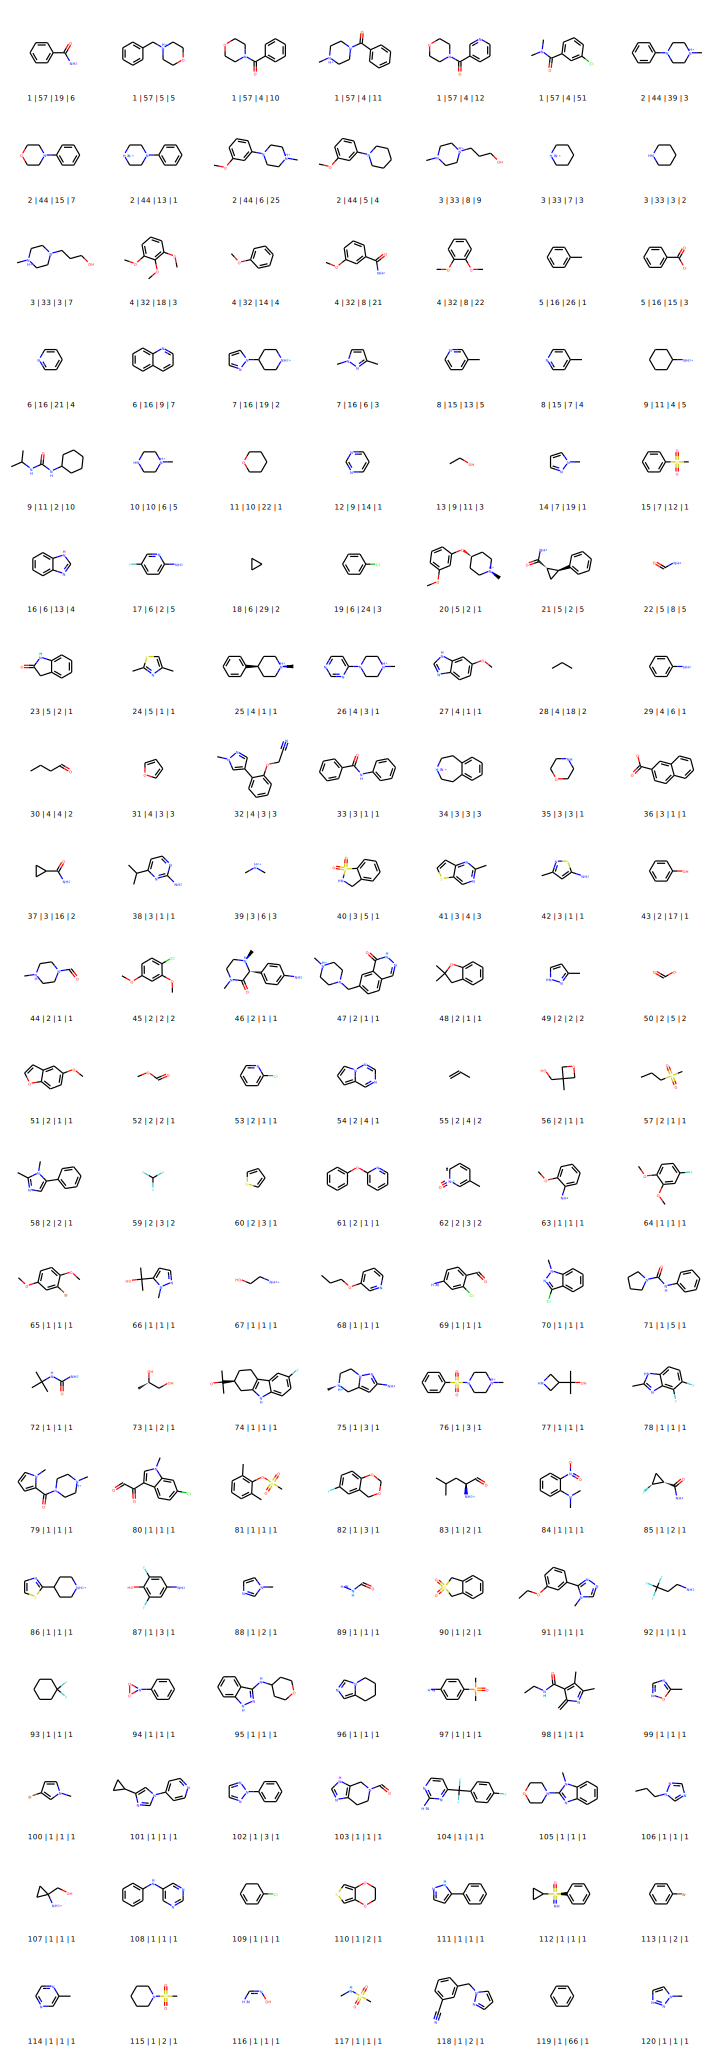

In [35]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('SE'), output_path=None)

### Fragments in GA

Legend: cluster ID | cluster size | fragment count | cluster member ID


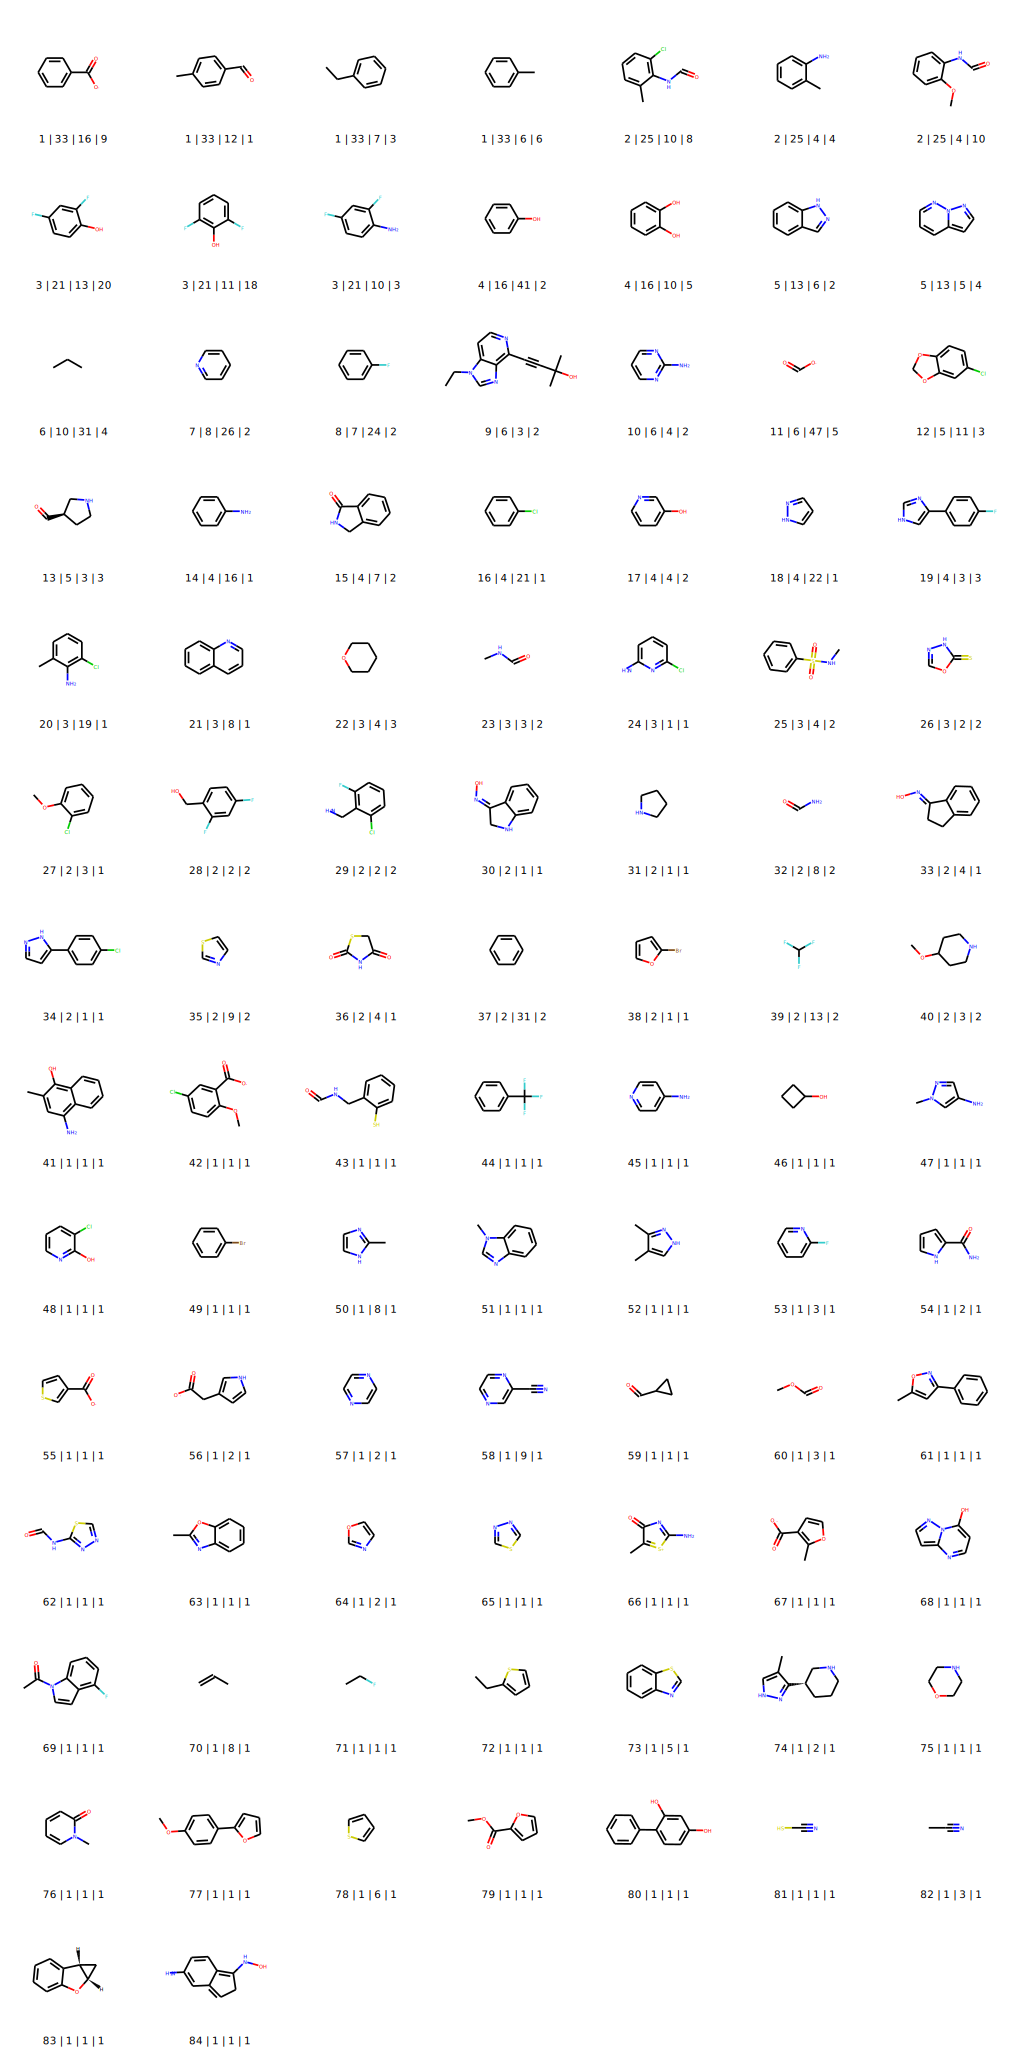

In [36]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('GA'), output_path=None)

### Fragments in B1

Legend: cluster ID | cluster size | fragment count | cluster member ID


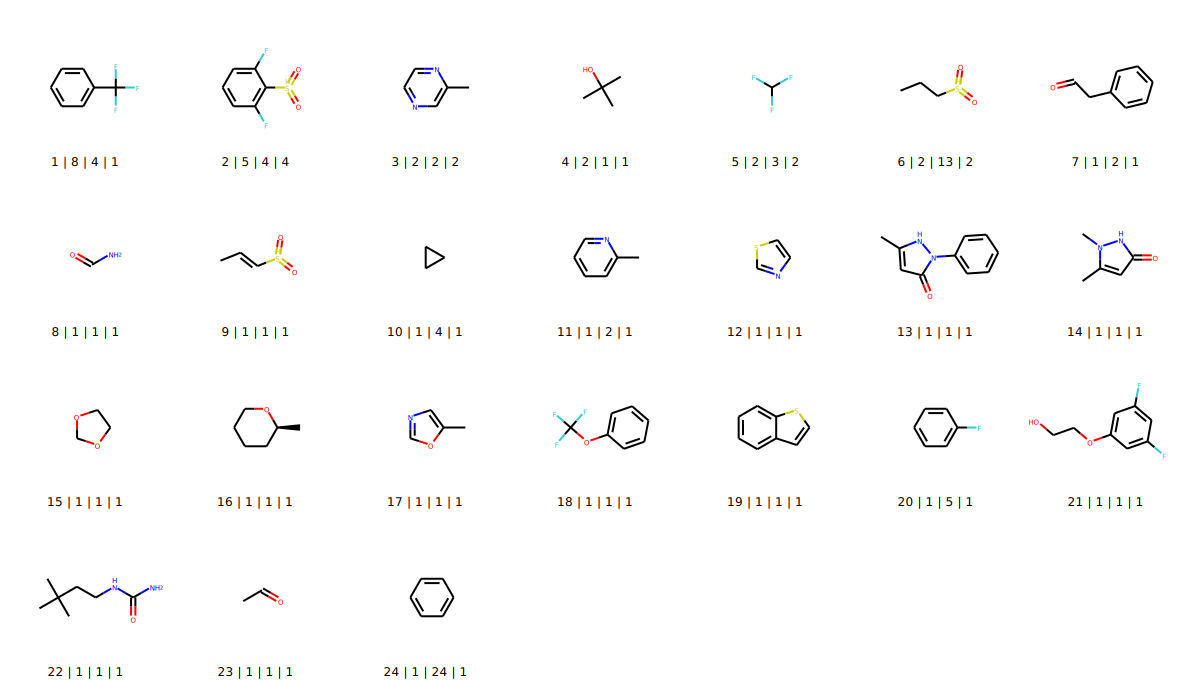

In [37]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('B1'), output_path=None)

### Fragments in B2

Legend: cluster ID | cluster size | fragment count | cluster member ID


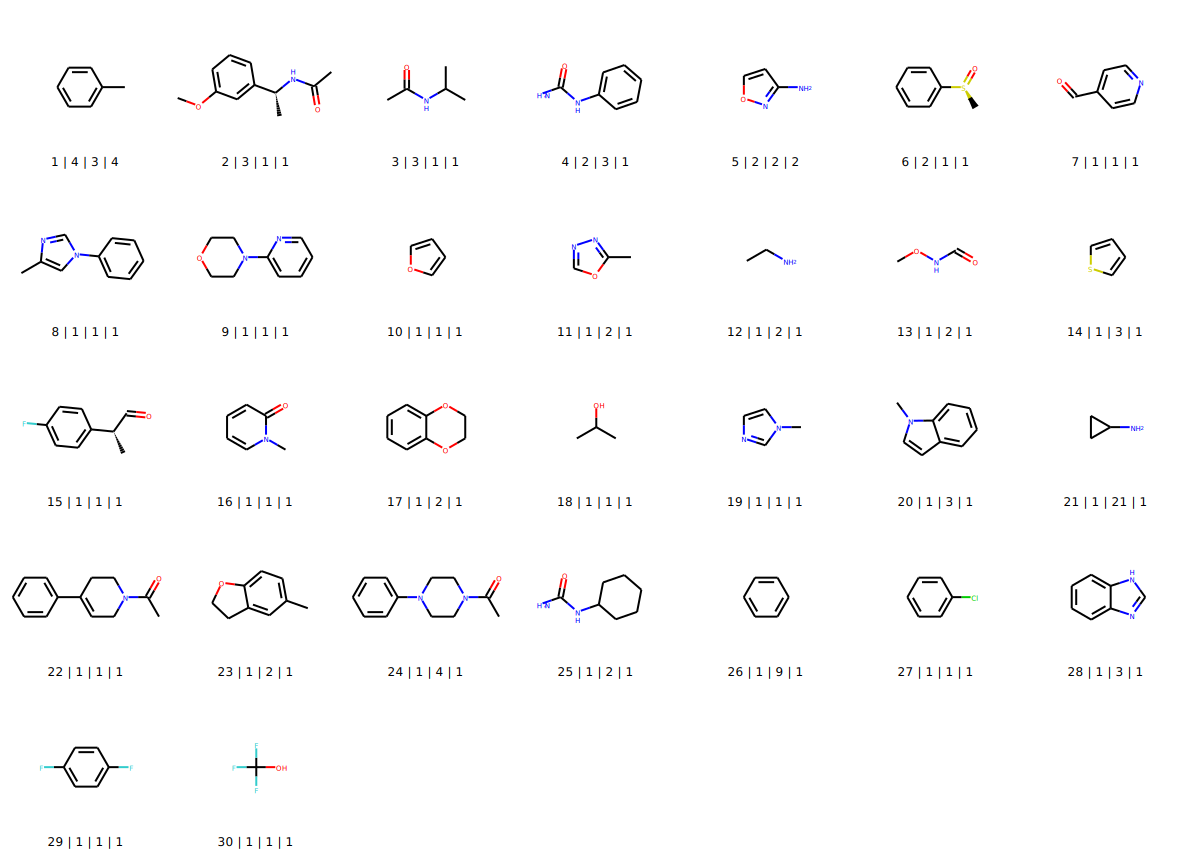

In [38]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('B2'), output_path=None)

## 5. Load fragment library (from sdf files)

Why, don't we have them already? Yes, we do, but without their original 3D coordinates. Although we do not need them in the current implementation of our recombination algorithm, we might be interested in the future.

In [39]:
# Get fragment library by subpocket
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

## 6. Which fragments in the full library are in the reduced library?

Loop over each subpocket pool in the full library and ask for each fragment if it is part of the respective reduced library's subpocket pool?

In [40]:
for subpocket, fragments in fragment_library.items():

    fragments['subpocket'] = subpocket
    
    if subpocket != 'X':
        
        fragments_reduced = selected_fragments.groupby('subpocket', sort=False).get_group(subpocket)
        
        smiles_match = fragments.smiles.isin(fragments_reduced.smiles)
        atom_environments_match = fragments.atom_environments.isin(fragments_reduced.atom_environments)
        fragments['in_reduced_library'] = smiles_match & atom_environments_match
    else:
        fragments['in_reduced_library'] = False

In [41]:
print(f'How many fragments are in reduced fragment library?')
print(selected_fragments.shape[0])

print(f'How many fragments in reduced library are part of full library? (sanity check)')
print(sum([fragments.groupby(['subpocket', 'smiles']).first().in_reduced_library.sum() for subpocket, fragments in fragment_library.items()]))

How many fragments are in reduced fragment library?
633
How many fragments in reduced library are part of full library? (sanity check)
633


## 7. How many ligands are fully covered by the reduced library?

In [42]:
# Group fragment library by kinase, complex and ligands to get all original ligands
original_ligands_groups = pd.concat(fragment_library).groupby(['kinase', 'complex_pdb', 'ligand_pdb'], sort=False)

# Is ligand fully covered, i.e. all fragments included (True or False)?
bool_ligand_is_fully_covered = original_ligands_groups.apply(
    lambda ligand: all(ligand.in_reduced_library)
)
bool_ligand_is_fully_covered.name = 'is_fully_covered'

# Is ligand covered with one or more fragments (True or False)?
bool_ligand_is_covered = original_ligands_groups.apply(
    lambda ligand: any(ligand.in_reduced_library)
)
bool_ligand_is_covered.name = 'is_covered'

# Make DataFrame
original_ligands = pd.concat([
    bool_ligand_is_fully_covered, bool_ligand_is_covered],
    axis=1
)
original_ligands.reset_index(inplace=True)

# Sometimes the same ligand is seen in multiple structures - keep only first ligand
print(f'Original ligands before ligand deduplication: {original_ligands.shape[0]}')
original_ligands = original_ligands.groupby('ligand_pdb', sort=False).first().reset_index()
print(f'Original ligands after ligand deduplication: {original_ligands.shape[0]}')

Original ligands before ligand deduplication: 2553
Original ligands after ligand deduplication: 2185


In [43]:
# Keep only fully covered ligands
original_ligands_fully_covered = original_ligands[original_ligands.is_fully_covered == True]

In [44]:
print(f'Number of selected fragments: {selected_fragments.shape[0]}')
print(f'Number of fully covered ligands by reduced fragment library: {original_ligands_fully_covered.shape[0]}')

Number of selected fragments: 633
Number of fully covered ligands by reduced fragment library: 48


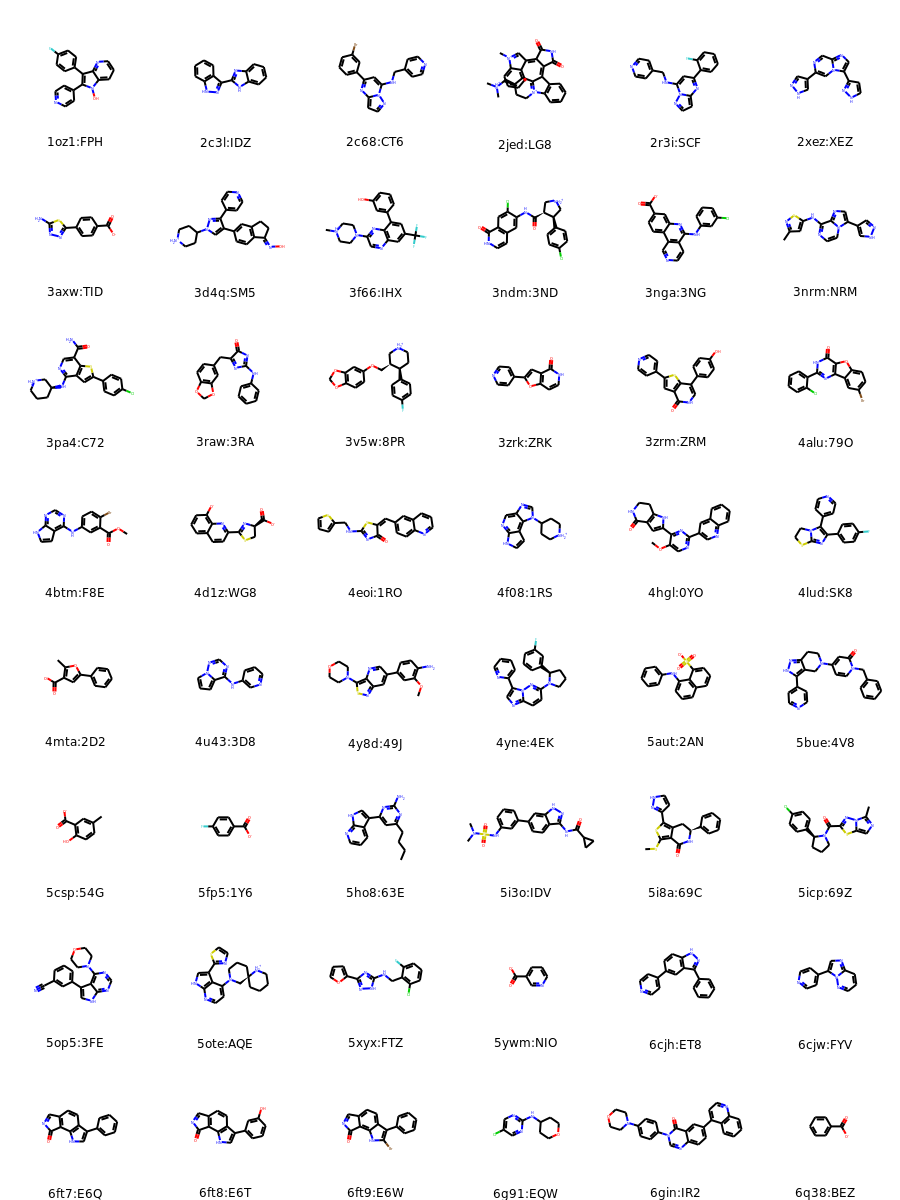

In [45]:
draw_ligands_from_pdb_ids(
    list(original_ligands_fully_covered.complex_pdb), 
    list(original_ligands_fully_covered.ligand_pdb), 
    mols_per_row=6
)

## 8. Save reduced fragment library (as sdf files and csv file)

In [46]:
def prepare_fragment_library_reduced(fragment_library):
    """
    Prepare data for sdf file (one file per subpocket) writing: Get fragment library (per subpocket) containing only fragments from the reduced fragment library.
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key), including "in_reduced_library" column.
        
    Returns
    -------
    dict of pandas.DataFrame
        Fragment details for reduced fragment library, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key), including "in_reduced_library" column.
    """

    fragment_library_reduced = fragment_library.copy()

    for subpocket, fragments in fragment_library_reduced.items():

        fragment_library_reduced[subpocket] = fragments[fragments.in_reduced_library == True]

    del fragment_library_reduced['X']
    
    return fragment_library_reduced

In [47]:
fragment_library_reduced = prepare_fragment_library_reduced(fragment_library)

### Save to sdf files

In [48]:
def save_reduced_fragment_library_to_sdfs(path_data, fragment_library_reduced, cutoff):
    """
    Save reduced fragment library to file (for each subpocket sdf file, all in a newly (if not existing) created "fragment_library_reduced" folder).
    
    Parameters
    ----------
    path_data : str or pathlib.Path
        Path to data folder (containing folders for fragment library and reduced fragment library).
    fragment_library_reduced : dict of pandas.DataFrame
        Fragment details for reduced fragment library, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key), including "in_reduced_library" column.
    cutoff : float
        Distance cutoff Butina clustering.
    """
    
    path_fragment_library_reduced = Path(path_data) / 'fragment_library_reduced'
    path_fragment_library_reduced.mkdir(parents=True, exist_ok=True)
    
    for subpocket, fragments in fragment_library_reduced.items():
        
        with open(path_fragment_library_reduced / f'{subpocket}_reduced_{cutoff}.sdf', 'w') as f:
            w = Chem.SDWriter(f)
            for mol in fragments.ROMol:
                w.write(mol)
            w.close()

In [49]:
save_reduced_fragment_library_to_sdfs(PATH_DATA, fragment_library_reduced, DISTANCE_CUTOFF)

### Save to csv file

In [50]:
def save_reduced_fragment_library_to_csv(path_data, fragment_library_concat_reduced, cutoff):
    """
    Save reduced fragment library to file (csv file, all in a newly (if not existing) created "fragment_library_reduced" folder).
    
    Parameters
    ----------
    path_data : str or pathlib.Path
        Path to data folder (containing folders for fragment library and reduced fragment library).
    fragment_library_concat_reduced : pandas.DataFrame
        Reduced fragment library data for one or multiple subpockets.
    cutoff : float
        Distance cutoff Butina clustering.
    """
    
    path_fragment_library_reduced = path_data / 'fragment_library_reduced'
    path_fragment_library_reduced.mkdir(parents=True, exist_ok=True)
    
    # Make copy of DataFrame for editing
    fragment_library_concat_reduced = fragment_library_concat_reduced.copy()
    
    # Save columns which are dropped in next step but will be added again at desired position
    column_smiles = fragment_library_concat_reduced.smiles
    column_subpockets = fragment_library_concat_reduced.subpocket
    
    # Drop columns (unneeded columns and columns that will be move to other position)
    fragment_library_concat_reduced.drop(
        ['ROMol', 'molecule_id', 'connections', 'connections_name', 'smiles', 'subpocket'], 
        axis=1,
        inplace=True
    )
    
    # Insert back columns which needed to be moved (to have the same order as in full library equivalent csv file)
    fragment_library_concat_reduced.insert(7, 'subpocket', column_subpockets)
    fragment_library_concat_reduced.insert(10, 'smiles', column_smiles)
    
    # Save to csv
    fragment_library_concat_reduced.to_csv(
        path_fragment_library_reduced / f'fragment_library_reduced_{cutoff}.csv', 
        index=False
    )

In [51]:
save_reduced_fragment_library_to_csv(PATH_DATA, selected_fragments, DISTANCE_CUTOFF)